In [1]:
import numpy as np 
import glob 
import vtk
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from AngioMorphPCA.preprocessing import parameterize_curve, calculate_3d_curve_abscissas,remove_high_freq_components, min_max_normalize, autocovariance_function
from AngioMorphPCA.io import Get_simple_vtk, makeVtkFile
from scipy.integrate import simps
from AngioMorphPCA.GenerateDiffHemeo import generate_diff_homeomorphism
from AngioMorphPCA.srvf_rep import compute_srvf_func, reconstruct_curve_from_srvf
from AngioMorphPCA.L2distance import calculate_l2_distance
from AngioMorphPCA.compute_geometry import compute_curvature_and_torsion,build_curve_from_curvatures
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from geomstats.learning.frechet_mean import FrechetMean
import geomstats.backend as gs
from geomstats.geometry.discrete_curves import (
    DiscreteCurvesStartingAtOrigin,
    SRVMetric,
    insert_zeros,
)
from geomstats.learning.pca import TangentPCA
import seaborn as sns
import matplotlib.cm as cm
import pandas as pd


# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def calculate_curve_length(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线的总长度。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        float: 曲线的总长度。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个差值的欧氏距离，并求和
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    total_length = segment_lengths.sum()
    
    return total_length

def calculate_abscissas(curve):
    """
    计算形状为 (n, 3) 的 3D 曲线每个点的累计弧长（abscissas）。
    
    参数:
        curve (numpy.ndarray): 形状为 (n, 3) 的 3D 曲线，包含 n 个点的坐标 (x, y, z)。
    
    返回:
        numpy.ndarray: 一个形状为 (n,) 的数组，包含每个点对应的累计弧长。
    """
    # 计算相邻点之间的差值
    diffs = np.diff(curve, axis=0)
    
    # 计算每个相邻点对之间的距离
    segment_lengths = np.sqrt((diffs ** 2).sum(axis=1))
    
    # 计算累计弧长，起始点的弧长为 0
    abscissas = np.concatenate(([0], np.cumsum(segment_lengths)))
    
    return abscissas

curve_bs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
curve_cs = np.load("../geom_aligned_curves_abj/geomstats_aligned_to_first_bravawithj.npy")[:-4]
# unaligned_curvatures = np.load("../unaligned_curvatures.npy")
files = np.load("../geom_aligned_curves_abj/total_files.npy")[:curve_bs.shape[0]]

print ("curve_bs.shape:", curve_bs.shape)
# print (unaligned_curvatures.shape)
print ("files length:", files.shape[0])

brava_num = len(curve_bs)
k_sampling_points = 120

original_centerlines = []
abscissas = []
for i in range(len(files)):
    # print ("files[i]:", files[i])
    original_centerline = Get_simple_vtk("../"+files[i])
    # print ("original_centerline.shape:", original_centerline.shape)
    print (calculate_curve_length(original_centerline), calculate_curve_length(curve_bs[i]))
    original_centerlines.append(original_centerline)
    abscissas.append(calculate_abscissas(original_centerline))



original_centerlines = np.array(original_centerlines)
abscissas = np.array(abscissas)

files_label = []
for i in range(len(files)):
    files_label.append("_".join([files[i].split('\\')[-1].split('.')[0].split('_')[0],files[i].split('\\')[-1].split('.')[0].split('_')[-1]]))

print (files_label)


INFO: Using numpy backend
INFO: Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: NumExpr defaulting to 8 threads.


curve_bs.shape: (79, 119, 3)
files length: 79
79.2532107896111 0.988287373259153
71.2856941716775 0.9807732379385738
81.99732061168635 0.9883072440705669
76.84593306337732 0.9868162645256428
84.42219706515498 0.98728184249317
82.51976985095165 0.9874980434120821
68.148084887353 0.9852561575309309
70.29056645709093 0.9867023434656611
62.64020846369101 0.9874736579534866
59.226106217694706 0.990212729475038
81.17170446694841 0.9872954676811688
72.55681136334347 0.9876538721878394
89.5732780821605 0.987967355093051
72.3216727210226 0.9862185350595626
93.31776822887464 0.98190259088653
90.63102213378802 0.981658770164441
68.49260917930133 0.9876193281470651
66.34326470721825 0.9865057656498606
78.0194813057584 0.9863008901413709
73.91862181493943 0.9810763130911232
80.31522199885775 0.979804324202744
80.39740696301176 0.9884739929810482
72.8872951189621 0.9846798402005845
72.45990096976132 0.9840407146592253
87.92834101687788 0.9860006746742415
84.83146452428466 0.9839835354707243
77.23885

In [2]:
k_sampling_points = 120

curves_r3 = DiscreteCurvesStartingAtOrigin(
    ambient_dim=3, k_sampling_points=k_sampling_points, equip=True
)

curves_r3.equip_with_metric(SRVMetric)

mean = FrechetMean(curves_r3)
mean.fit(curve_cs)

mean_estimate = mean.estimate_
tangent_base = mean.estimate_


d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:38: RuntimeWarning: invalid value encountered in divide
  curvature = np.where(r_prime_norm**3 > epsilon, cross_norm / (r_prime_norm ** 3), 0)
d:\!BraVa_src\ica_results\src\AngioMorphPCA\compute_geometry.py:41: RuntimeWarning: invalid value encountered in divide
  torsion = np.where(cross_norm**2 > epsilon, torsion_numerator / (cross_norm ** 2), 0)


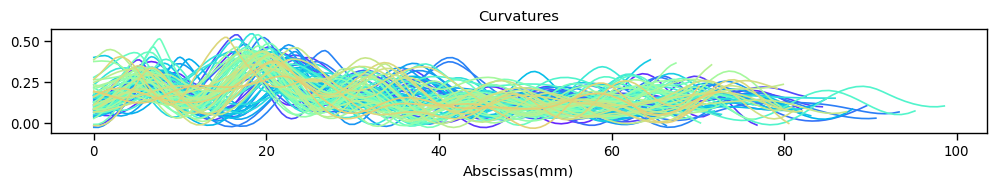

In [3]:


def set_x_ticks_normalized(ax,x_array,num=5):
    ax.set_xlim(0, len(x_array) - 1)
    ax.set_xticks(np.linspace(0, len(x_array)-1, num=num))
    ax.set_xticklabels(['{:.2f}'.format(x) for x in np.linspace(0, 1, num=num)])
    ax.autoscale(enable=True, axis='x', tight=True)


curvatures = []
torsions = []
lengths = []
for i in range(len(curve_cs)):
    c,t = compute_curvature_and_torsion(original_centerlines[i])
    fft_c = remove_high_freq_components(c,0.05)
    fft_t = remove_high_freq_components(t,0.05)
    curvatures.append(fft_c)
    lengths.append(calculate_curve_length(original_centerlines[i]))
    torsions.append(fft_t)
curvatures = np.array(curvatures)
torsions = np.array(torsions)
lengths = np.array(lengths)

# 假设 curve_cs、abscissas、curvatures、torsions 已定义
# 使用 viridis 调色板
num_curves = len(curve_cs)
# colors = cm.hsv(np.linspace(0, 1, num_curves))  # 为每条曲线生成一个颜色
colors = cm.rainbow(np.linspace(0.05, 0.70, num_curves))
sns.set_context("paper", font_scale=1.1)
fig = plt.figure(figsize=(10, 2))
ax1 = fig.add_subplot(111)
# ax2 = fig.add_subplot(212)

for i in range(num_curves):
    ax1.plot(abscissas[i], curvatures[i], color=colors[i], label='curve {}'.format(i))
    # ax2.plot(abscissas[i], torsions[i], color=colors[i], label='curve {}'.format(i))

ax1.set_title('Curvatures')
# ax2.set_title('Torsions')
ax1.set_xlabel('Abscissas(mm)')
# ax2.set_xlabel('Abscissas(mm)')


plt.tight_layout()
plt.show()

In [4]:
print (files_label)

import vtk
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy

def read_vtk_maximum_inscribed_sphere(file_path):
    """
    Reads a .vtk file and extracts point data with the name 'MaximumInscribedSphere'.

    Parameters:
        file_path (str): The path to the .vtk file.

    Returns:
        np.ndarray: The array of 'MaximumInscribedSphere' data, or None if not found.
    """
    # Create a VTK reader
    reader = vtk.vtkGenericDataObjectReader()
    reader.SetFileName(file_path)
    reader.Update()

    # Get the data from the file
    data = reader.GetOutput()

    if data is None:
        raise ValueError(f"No data found in file: {file_path}")

    # Get point data
    point_data = data.GetPointData()
    if point_data is None:
        raise ValueError("No point data found in the VTK file.")

    # Extract the array with the name 'MaximumInscribedSphere'
    max_inscribed_sphere_data = point_data.GetArray("MaximumInscribedSphereRadius")
    if max_inscribed_sphere_data is None:
        raise ValueError("'MaximumInscribedSphereRadius' data not found in the point data.")

    # Convert the data to a NumPy array
    data_array = vtk_to_numpy(max_inscribed_sphere_data)

    return data_array

# Collect statistics from multiple files
def collect_statistics_from_files(file_paths):
    """
    Collects statistics for MaximumInscribedSphere from a list of VTK files.

    Parameters:
        file_paths (list): List of file paths to .vtk files.

    Returns:
        dict: Dictionary containing max, min, mean, and variance of the data.
    """
    all_data = []

    for file_path in file_paths:
        try:
            data = read_vtk_maximum_inscribed_sphere(file_path)
            all_data.extend(data)  # Combine data from all files
        except ValueError as e:
            print(f"Warning: {e} (file: {file_path})")

    if not all_data:
        raise ValueError("No valid data found in the provided files.")

    all_data = np.array(all_data)

    return {
        "Max": np.max(all_data),
        "Min": np.min(all_data),
        "Mean": np.mean(all_data),
        "Variance": np.var(all_data),
    }

# Main script
r_files = glob.glob("D:/!BraVa_src/src/ModeDecomposition/scaling/resamp_attr_ascii/vmtk64a/*.vtk")
stats = collect_statistics_from_files(r_files)

# Display statistics
print("Statistics for MaximumInscribedSphere:")
print(f"Max: {stats['Max']}")
print(f"Min: {stats['Min']}")
print(f"Mean: {stats['Mean']}")
print(f"Variance: {stats['Variance']}")

['BG0001_L', 'BG0001_R', 'BG0004_L', 'BG0004_R', 'BG0006_L', 'BG0006_R', 'BG0007_L', 'BG0007_R', 'BG0008_L', 'BG0008_R', 'BG0009_L', 'BG0009_R', 'BG0010_L', 'BG0010_R', 'BG0011_L', 'BG0011_R', 'BG0012_L', 'BG0012_R', 'BG0017_L', 'BG0017_R', 'BG0018_L', 'BG0018_R', 'BG0019_L', 'BG0019_R', 'BG0020_L', 'BG0020_R', 'BG0021_R', 'BG0022_L', 'BG0022_R', 'BH0005_L', 'BH0005_R', 'BH0006_L', 'BH0006_R', 'BH0009_L', 'BH0009_R', 'BH0010_L', 'BH0010_R', 'BH0011_L', 'BH0011_R', 'BH0013_L', 'BH0013_R', 'BH0014_L', 'BH0014_R', 'BH0016_L', 'BH0016_R', 'BH0017_L', 'BH0017_R', 'BH0018_L', 'BH0018_R', 'BH0019_L', 'BH0019_R', 'BH0020_L', 'BH0020_R', 'BH0021_L', 'BH0023_L', 'BH0024_L', 'BH0024_R', 'BH0025_R', 'BH0026_L', 'BH0026_R', 'BH0029_L', 'BH0029_R', 'BH0030_L', 'BH0030_R', 'BH0031_L', 'BH0031_R', 'BH0034_L', 'BH0034_R', 'BH0035_L', 'BH0035_R', 'BH0036_L', 'BH0036_R', 'BH0038_L', 'BH0038_R', 'BH0039_L', 'BH0039_R', 'BH0040_R', 'BI0001_L', 'BI0001_R']
Statistics for MaximumInscribedSphere:
Max: 3.69000

In [5]:
for i in range(len(curvatures)):
    for j in range(len(curvatures[i])):
        if curvatures[i][j] < 0:
            print ("curvatures[i][j]:", curvatures[i][j])
            # curvatures[i][j] = 0

curvatures[i][j]: -0.0012445377002382684
curvatures[i][j]: -0.004296142638915712
curvatures[i][j]: -5.4109004602276296e-05
curvatures[i][j]: -0.01562503203120249
curvatures[i][j]: -0.02551503172896557
curvatures[i][j]: -0.026656756301831237
curvatures[i][j]: -0.01908901382326017
curvatures[i][j]: -0.00353052901014218
curvatures[i][j]: -0.017472912007925633
curvatures[i][j]: -0.011132669585865751
curvatures[i][j]: -0.012207920651781615
curvatures[i][j]: -0.00761669666889578
curvatures[i][j]: -0.013229491489628915
curvatures[i][j]: -0.01306200616704598
curvatures[i][j]: -0.006209887422907319
curvatures[i][j]: -0.0030006016339619115
curvatures[i][j]: -0.006050153162581466
curvatures[i][j]: -0.002029097100322404
curvatures[i][j]: -0.018172819172771516
curvatures[i][j]: -0.02195128719387194
curvatures[i][j]: -0.012787687693467224
curvatures[i][j]: -0.008367863268145322
curvatures[i][j]: -0.019206576493811595
curvatures[i][j]: -0.0171893628658147
curvatures[i][j]: -0.0016800162917246803
curv

In [6]:
# 存储统计结果
statistics = {
    "Length": {
        "Max": np.max(lengths),
        "Min": np.min(lengths),
        "Mean": np.mean(lengths),
        "Variance": np.var(lengths)
    },
    "Curvature": {
        "Max": np.max([np.max(curve) for curve in curvatures]),
        "Min": np.min([np.min(curve) for curve in curvatures]),
        "Mean": np.mean([np.mean(curve) for curve in curvatures]),
        "Variance": np.var([np.var(curve) for curve in curvatures])
    },
    # "Torsion": {
    #     "Max": np.max([np.max(curve) for curve in torsions]),
    #     "Min": np.min([np.min(curve) for curve in torsions]),
    #     "Mean": np.mean([np.mean(curve) for curve in torsions]),
    #     "Variance": np.var([np.var(curve) for curve in torsions])
    # }
}

# 转换为 DataFrame 格式
df_statistics = pd.DataFrame(statistics)

# 显示数据
df_statistics

,Length,Curvature
Max,98.560688,0.542393
Min,59.226106,-0.031036
Mean,75.079549,0.171662
Variance,61.434700,0.000010


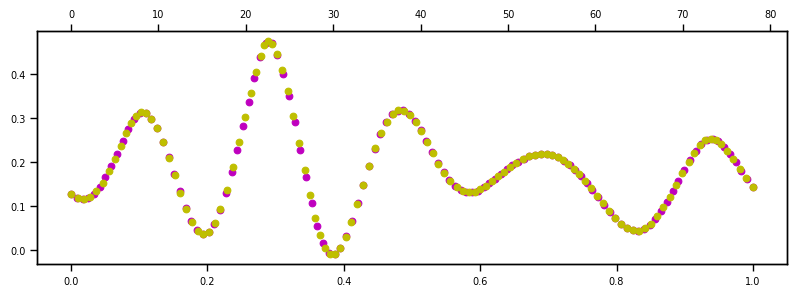

In [7]:
import numpy as np
from scipy.interpolate import interp1d

def parameterize_1d_curve(curve, abscissas):
    """
    Create a function to parameterize a 1D curve with non-uniform abscissas.
    
    :param curve: A 1D numpy array representing the curve's discrete y-values.
    :param abscissas: A 1D numpy array representing the x-values (abscissas) of the curve, should be the same length as `curve`.
    :return: A function that takes a vector of parameter values (t) and returns interpolated points on the curve.
    """
    # Normalize abscissas to the range [0, 1] for consistent parameterization
    t_values = (abscissas - abscissas.min()) / (abscissas.max() - abscissas.min())

    # Create an interpolation function for the curve
    interpolate_y = interp1d(t_values, curve, kind='cubic', fill_value="extrapolate")

    def curve_function(t_vector):
        # Clamp t_vector values to be within [0, 1]
        t_vector_clamped = np.clip(t_vector, 0, 1)
        
        # Interpolate y-values at the given t values
        y = interpolate_y(t_vector_clamped)
        return y

    return curve_function


reparam_curvatures = []
# 计算参数 t 在 [0, 1] 内的几个点上的插值值
t_vector = np.linspace(0, 1, curvatures.shape[1])
for i in range(len(files)):
    curve_func = parameterize_1d_curve(curvatures[i], abscissas[i])
    interpolated_points = curve_func(t_vector)
    reparam_curvatures.append(interpolated_points)

reparam_curvatures = np.array(reparam_curvatures)

i=18
sns.set_context("paper", font_scale=0.8)
fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(111)
ax.scatter(t_vector, reparam_curvatures[i], color='m',label='Interpolated Curve')
ax2 = ax.twiny()
ax2.scatter(abscissas[i], curvatures[i], color='y', label='Original Curve Points')
# ax.legend()
# ax.set_title('Interpolated Curve vs. Original Points')
plt.tight_layout()
plt.show()

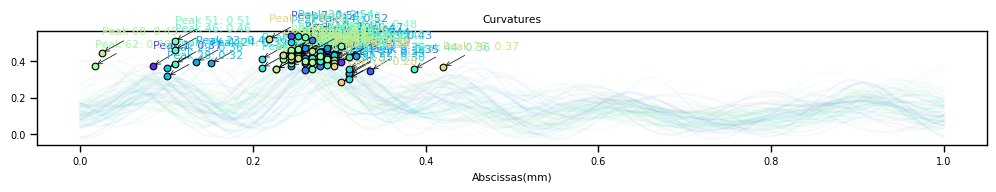

In [8]:

fig = plt.figure(figsize=(10, 2))
ax1 = fig.add_subplot(111)
# 遍历每条曲线
for i in range(num_curves):

    # 绘制曲线
    ax1.plot(t_vector, reparam_curvatures[i], color=colors[i], label='curve {}'.format(i), alpha=0.05)

    # 找到最高的峰值及其索引
    max_idx = np.argmax(reparam_curvatures[i])  # 找到最大值索引
    max_value = reparam_curvatures[i][max_idx]  # 最大值

    # 在图中标注最高峰
    ax1.scatter(t_vector[max_idx], max_value, color=colors[i], edgecolor='black', zorder=5)
    ax1.annotate(
        f'Peak {i+1}: {max_value:.2f}',  # 标注文本
        xy=(t_vector[max_idx], max_value),  # 标注位置
        xytext=(t_vector[max_idx], max_value + 0.1),  # 偏移位置
        arrowprops=dict(facecolor=colors[i], arrowstyle='->', lw=0.5),
        fontsize=8,
        color=colors[i]
    )

# 设置标题和标签
ax1.set_title('Curvatures')
ax1.set_xlabel('Abscissas(mm)')

plt.tight_layout()
plt.show()


In [9]:
# !pip install scikit-fda
from skfda.datasets import fetch_growth, make_multimodal_samples
from skfda.exploratory.stats import fisher_rao_karcher_mean
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda import FDataGrid

# curvatures = curve_bs[:,:,2]

# n, k = curvatures.shape
# print (n, k)
# x_grid = np.linspace(0, 1, k)
# x_grid = t_vector.copy()

# fd = FDataGrid(data_matrix=reparam_curvatures, grid_points=x_grid)

# # 创建 FisherRaoElasticRegistration 对象
# elastic_registration = FisherRaoElasticRegistration()

# # 执行曲线对齐
# fd_aligned = elastic_registration.fit_transform(fd)

# # 计算对齐后的均值曲线 (Karcher Mean)
# mean_function = fisher_rao_karcher_mean(fd_aligned).data_matrix[0,:,0]
# print ("mean_function.shape:", mean_function.shape)


# # 将对齐后的曲线数据提取为 numpy array
# aligned_curvatures = fd_aligned.data_matrix[:,:,0]
# print ("aligned_curves.shape:", aligned_curvatures.shape)

# # 提取变形函数
# warping_functions = elastic_registration.warping_.data_matrix[:,:,0]
# print ("warping_functions.shape:", warping_functions.shape)
# elastic_registration.warping_.plot()

In [10]:
from scipy.signal import find_peaks
def find_peaks_and_troughs(reparam_curvature):
    """
    找到以下特定的峰值和谷值索引：
    - 第一个峰值 p1
    - 第一个谷值 t1
    - 第二个峰值 p2
    - 第二个谷值 t2
    - 第三个峰值 p3

    参数:
        reparam_curvature (numpy.ndarray): 一维数组，表示曲线数据。
    
    返回:
        list: [p1, t1, p2, t2, p3]
    """
    peaks, _ = find_peaks(reparam_curvature)  # 找到所有峰值
    troughs, _ = find_peaks(-reparam_curvature)  # 找到所有谷值

    if len(peaks) < 2:
        raise ValueError("The curve does not have enough peaks to meet the criteria.")

    # 确定最高峰值的索引（全局最大值）
    global_max_idx = np.argmax(reparam_curvature[peaks])
    global_max_peak = peaks[global_max_idx]

    # 确定 p1 和 p2
    p1 = None
    p2 = None
    if global_max_idx > 0:  # 最高峰前还有其他峰值
        p2 = global_max_peak
        p1 = peaks[global_max_idx - 1]
    else:  # 最高峰前没有其他峰值
        p1 = global_max_peak
        p2 = peaks[global_max_idx + 1]

    # 确定 p2 后的第三个峰值 p3
    p3_candidates = peaks[peaks > p2]
    if len(p3_candidates) == 0:
        raise ValueError("No peaks found after p2.")
    p3 = p3_candidates[0]  # p3 是 p2 后的第一个峰值

    # 确定 p1 和 p2 之间的谷值 t1
    t1_candidates = troughs[(troughs > p1) & (troughs < p2)]
    if len(t1_candidates) == 0:
        raise ValueError("No troughs found between p1 and p2.")
    t1 = t1_candidates[np.argmin(reparam_curvature[t1_candidates])]

    # 确定 p2 和 p3 之间的谷值 t2
    t2_candidates = troughs[(troughs > p2) & (troughs < p3)]
    if len(t2_candidates) == 0:
        raise ValueError("No troughs found between p2 and p3.")
    t2 = t2_candidates[np.argmin(reparam_curvature[t2_candidates])]

    # 返回结果列表
    result = [p1, t1, p2, t2, p3]

    # 检查结果是否递增
    if not all(x < y for x, y in zip(result, result[1:])):
        raise ValueError(f"The result list is not strictly increasing: {result}")

    return result


landmarks = []
for i in range(len(reparam_curvatures)):
    # print (i)
    all_indices = find_peaks_and_troughs(reparam_curvatures[i])
    # print ("all_indices:", len(all_indices))
    landmarks.append(all_indices)

landmarks = np.array(landmarks)/120
# print (landmarks)

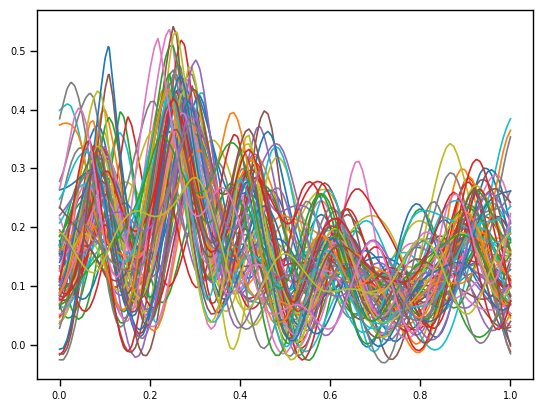

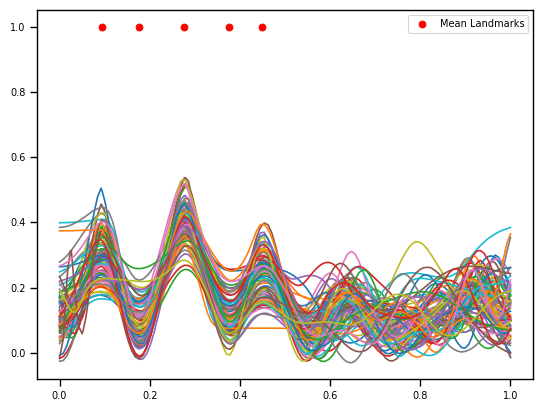

In [11]:
import numpy as np
from skfda.preprocessing.registration import landmark_elastic_registration
from skfda import FDataGrid

x_grid = t_vector.copy()
# print (x_grid)
fd = FDataGrid(data_matrix=reparam_curvatures, grid_points=x_grid)

# 使用 landmark_elastic_registration 对齐曲线
fd_registered = landmark_elastic_registration(fd, landmarks)

# 绘制原始曲线
fd.plot(legend=True)

# 绘制对齐后的曲线
fd_registered.plot(legend=True)

# 可选：可视化标志点
plt.scatter(np.mean(landmarks, axis=0), [1] * len(np.mean(landmarks, axis=0)), color='red', label="Mean Landmarks")
plt.legend()
plt.show()

(79, 5)


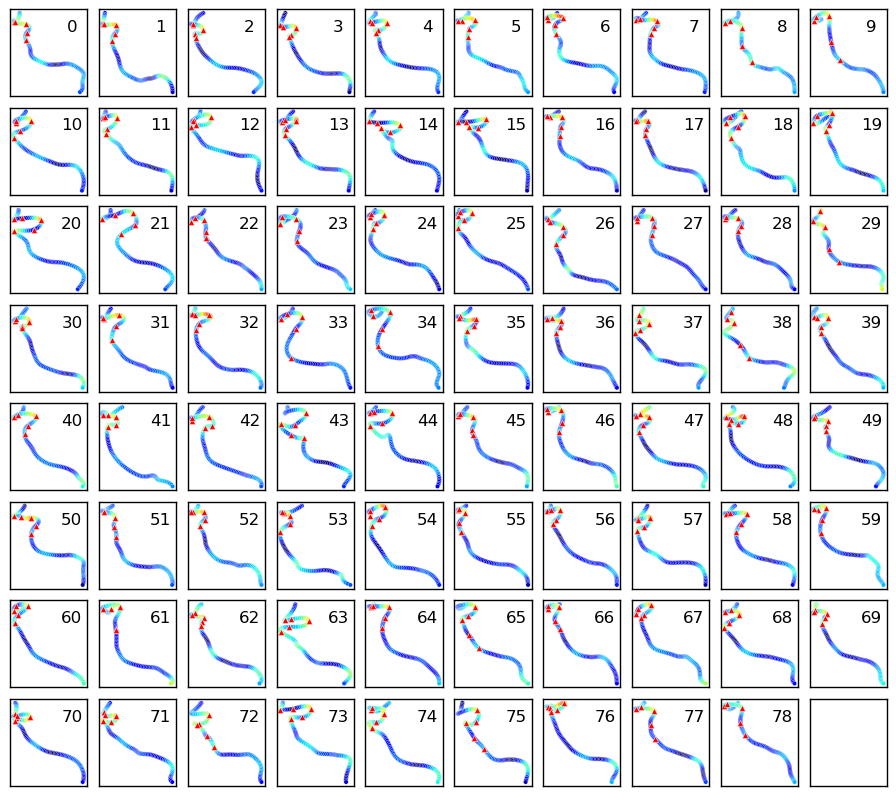

In [64]:
import matplotlib.colors as mcolors

# 创建一个固定范围的归一化对象
norm = mcolors.Normalize(vmin=0, vmax=0.6)

def rotate_curves(curves, angle, axis):
    """
    旋转3D曲线数据集。
    
    :param curves: numpy数组，形状为(n, k, 3)，n是曲线数，k是每条曲线的点数。
    :param angle: 旋转角度，以度为单位。
    :param axis: 旋转轴，'x'、'y'或'z'。
    :return: 旋转后的曲线数据集。
    """
    # 将角度从度转换为弧度
    theta = np.radians(angle)
    
    # 根据轴选择旋转矩阵
    if axis == 'x':
        R = np.array([[1, 0, 0],
                      [0, np.cos(theta), -np.sin(theta)],
                      [0, np.sin(theta), np.cos(theta)]])
    elif axis == 'y':
        R = np.array([[np.cos(theta), 0, np.sin(theta)],
                      [0, 1, 0],
                      [-np.sin(theta), 0, np.cos(theta)]])
    elif axis == 'z':
        R = np.array([[np.cos(theta), -np.sin(theta), 0],
                      [np.sin(theta), np.cos(theta), 0],
                      [0, 0, 1]])
    else:
        raise ValueError("Axis must be 'x', 'y', or 'z'")
    
    # 应用旋转矩阵到每个点
    rotated_curves = np.dot(curves, R.T)
    
    return rotated_curves

ro = rotate_curves(curve_bs, 45, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度
int_landmarks = np.array(landmarks*120,dtype=int)
print (int_landmarks.shape)

row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8),dpi=100)


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            sns.scatterplot(x=ro[i*col+j,:,0], y=ro[i*col+j,:,1], ax=ax, alpha=1,s=10, c=reparam_curvatures[i*col+j][:119], cmap='jet',norm=norm)
            sns.scatterplot(x=ro[i*col+j,int_landmarks[i*col+j],0], y=ro[i*col+j,int_landmarks[i*col+j],1], ax=ax, alpha=1,s=20, c='red',marker='^')
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.8, 0.8, f'{i*col + j}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


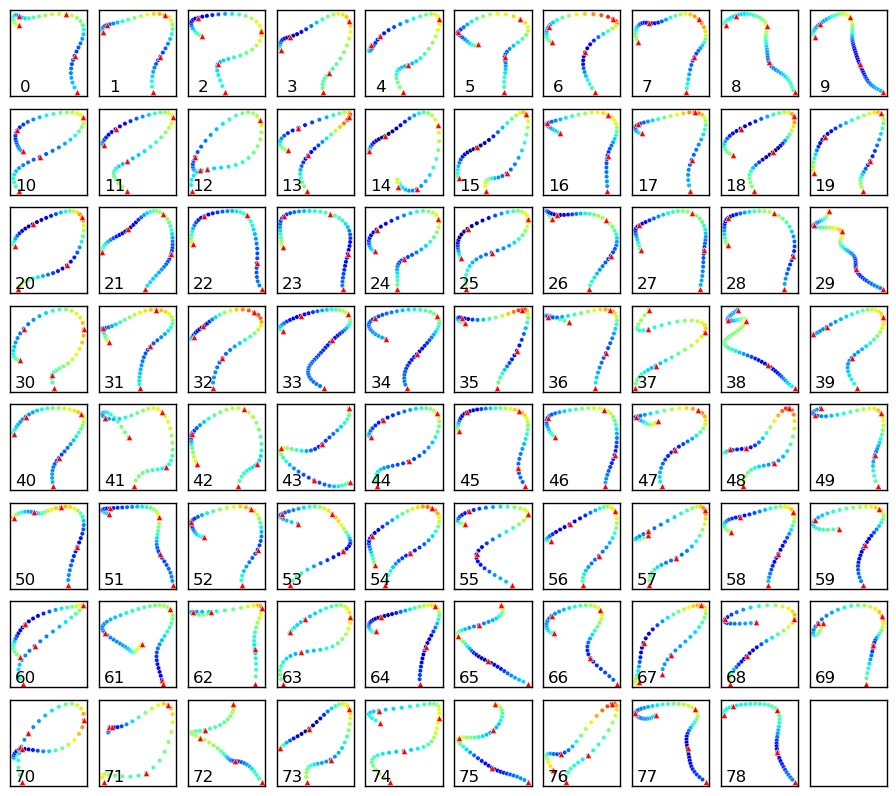

In [65]:

ro = rotate_curves(curve_bs, 60, 'x')  # 绕Z轴旋转45度
ro = rotate_curves(ro, 5, 'z')  # 绕Z轴旋转45度
ro = rotate_curves(ro, -15, 'y')  # 绕Z轴旋转45度


row = 8
col = 10
fig, axes = plt.subplots(nrows=row, ncols=col, figsize=(9, 8),dpi=100)


shift_c= []
shift_t= []
# 遍历每个子图，并在其中绘制一些数据
for i in range(row):
    for j in range(col):
        ax = axes[i, j]  # 获取单个子图对象
        ax.set_xticks([])
        ax.set_yticks([])
        if i*col+j < 79:
            sns.scatterplot(x=ro[i*col+j,int_landmarks[i*col+j][0]:int_landmarks[i*col+j][-1],0], y=ro[i*col+j,int_landmarks[i*col+j][0]:int_landmarks[i*col+j][-1],1], ax=ax, alpha=1,s=10, c=reparam_curvatures[i*col+j][int_landmarks[i*col+j][0]:int_landmarks[i*col+j][-1]], cmap='jet',norm=norm)
            sns.scatterplot(x=ro[i*col+j,int_landmarks[i*col+j],0], y=ro[i*col+j,int_landmarks[i*col+j],1], ax=ax, alpha=1,s=20, c='red',marker='^')
            # sns.scatterplot(x=ro[i*col+j,trough_indices_reparam[i*col+j],0], y=ro[i*col+j,trough_indices_reparam[i*col+j],1], ax=ax, alpha=1,s=10, c='k')
            
            
            # ax.set_title(f'{i*col + j + 1}', fontsize=8)  # 设置子图的标题
            ax.text(0.2, 0.1, f'{i*col + j}', fontsize=12, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.5, f't:{elastic_t}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.text(0.5, 0.3, f'c:{elastic_c}', fontsize=9, ha='center', va='center', transform=ax.transAxes)
            # ax.set_facecolor(facecolor)

# 调整子图之间的间距
plt.tight_layout()

# 显示整个大图
plt.show()


In [86]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
bad_curve_index = [29,33, 38,43, 44,61,65,67,72,75,76,77]
good_curve_index = [i for i in range(79) if i not in bad_curve_index]
good_curve_index = np.array(good_curve_index)
bad_curve_index = np.array(bad_curve_index)

# good_curvatures = curvatures[good_curve_index]
# bad_curvatures = curvatures[bad_curve_index]
good_curvatures = reparam_curvatures[good_curve_index]
bad_curvatures = reparam_curvatures[bad_curve_index]

good_int_landmarks = int_landmarks[good_curve_index]
bad_int_landmarks = int_landmarks[bad_curve_index]

good_original_centerlines = original_centerlines[good_curve_index]
bad_original_centerlines = original_centerlines[bad_curve_index]

good_normalized_centerlines = curve_bs[good_curve_index]
bad_normalized_centerlines = curve_bs[bad_curve_index]

# good_int_p2 = good_int_landmarks[:,2].reshape(-1,1)
# bad_int_p2 = bad_int_landmarks[:,2].reshape(-1,1)
# print (good_int_landmarks[0])
# print (good_curvatures[0])

def generate_masks(curves, landmarks):
    """
    根据每条曲线的 landmarks 生成掩码。
    掩码标记 p1 到 p2 区间为 1，其他区域为 0。
    
    :param curves: list of numpy arrays，每条曲线的曲率数据。
    :param landmarks: list of numpy arrays，每条曲线的关键点索引 [p1, t1, p2, t2, p3]。
    :return: 掩码矩阵，形状与 curves 相同。
    """
    masks = []
    for curve, landmark in zip(curves, landmarks):
        mask = np.zeros_like(curve, dtype=int)
        p1, p2 = landmark[0], landmark[-1]  # 取出 p1 和 p2 的索引
        mask[p1:p2+1] = 1  # p1 到 p2 的区间标记为 1
        masks.append(mask)
    return np.array(masks)

class CurvatureDataset(Dataset):
    def __init__(self, curves, masks):
        """
        :param curves: 曲率数据，list of numpy arrays。
        :param masks: 掩码数据，list of numpy arrays，表示 p1 到 p2 的区域。
        """
        self.curves = torch.tensor(curves, dtype=torch.float32)
        self.masks = torch.tensor(masks, dtype=torch.long)

    def __len__(self):
        return len(self.curves)

    def __getitem__(self, idx):
        return self.curves[idx], self.masks[idx]



# 生成掩码
# masks = generate_masks(good_curvatures, good_int_landmarks)


Epoch 1/50, Loss: 0.47055645287036896
Relaxed Boundary Accuracy: 34.81%
Validation Accuracy: 34.81%
Epoch 2/50, Loss: 0.17373813688755035
Relaxed Boundary Accuracy: 34.62%
Validation Accuracy: 34.62%
Epoch 3/50, Loss: 0.06052330136299133
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 4/50, Loss: 0.0635191947221756
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 5/50, Loss: 0.059035465121269226
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 6/50, Loss: 0.06828153133392334
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 7/50, Loss: 0.05694034695625305
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 8/50, Loss: 0.060472965240478516
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 9/50, Loss: 0.0546204149723053
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%
Epoch 10/50, Loss: 0.06250987946987152
Relaxed Boundary Accuracy: 35.13%
Validation Accuracy: 35.13%

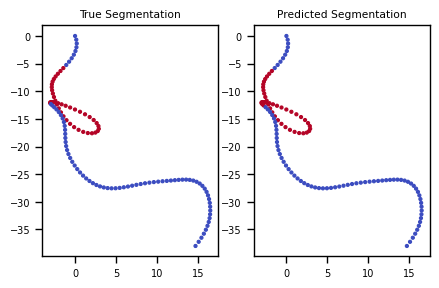

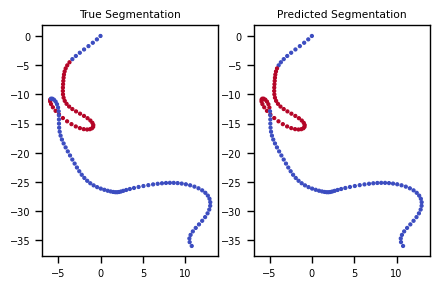

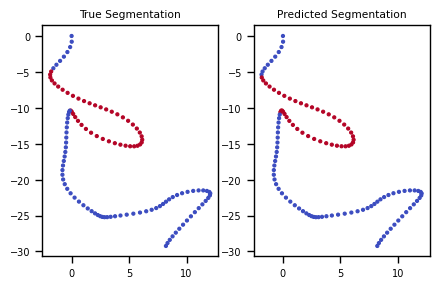

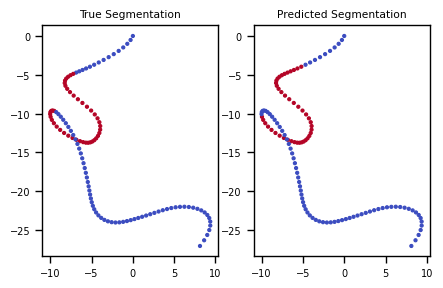

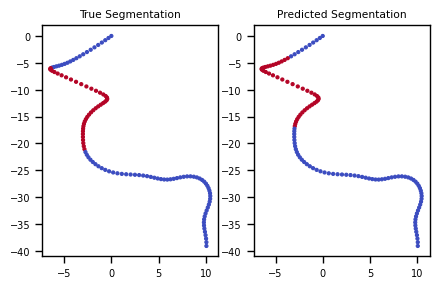

bad cases
Plotting centerlines.


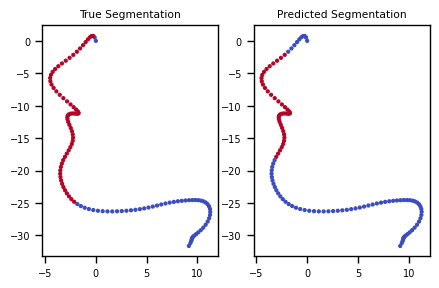

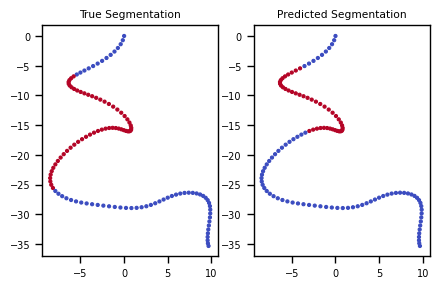

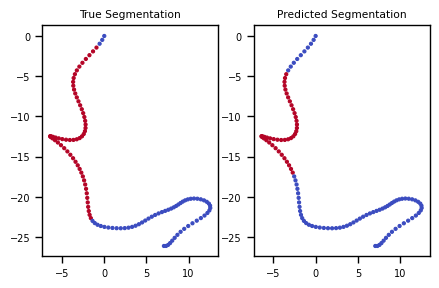

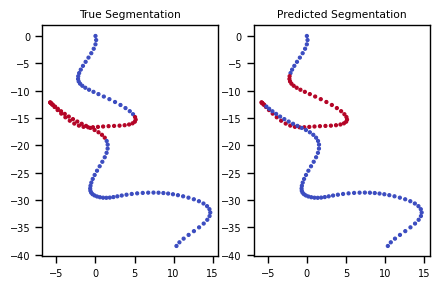

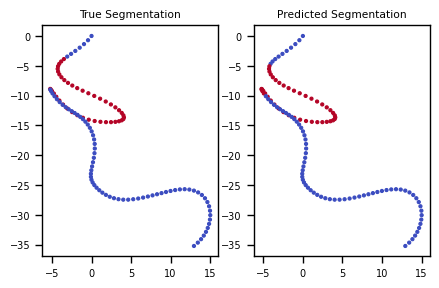

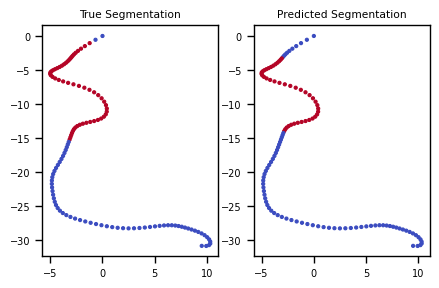

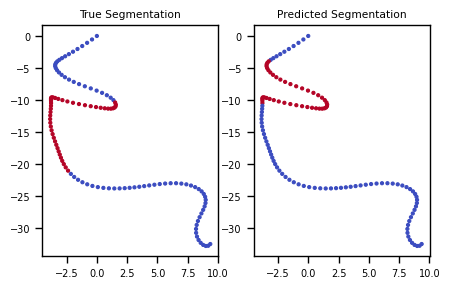

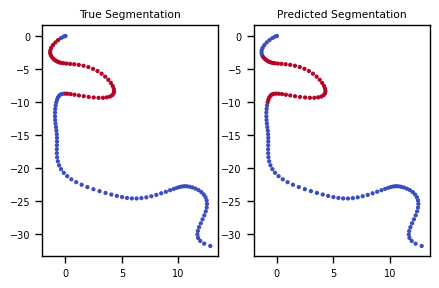

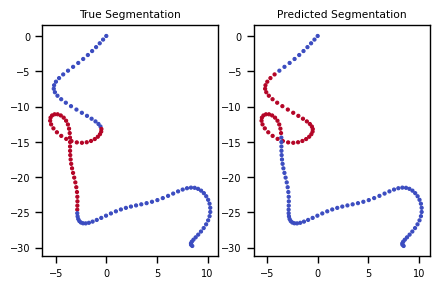

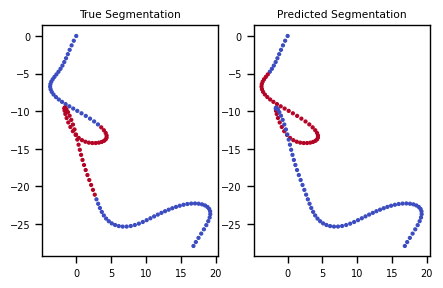

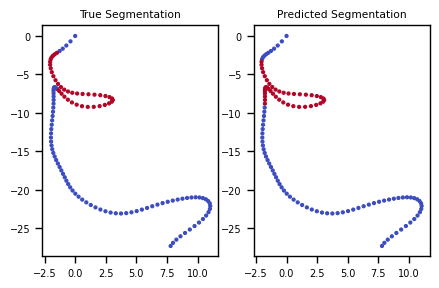

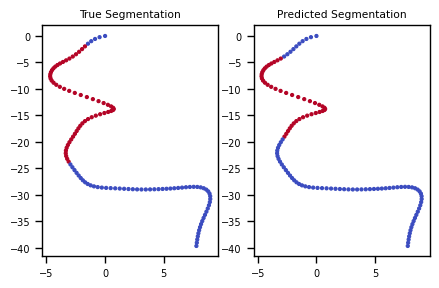

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# 定义 DiceLoss
class DiceLoss(nn.Module):
    def forward(self, outputs, targets):
        """
        :param outputs: 模型输出 [batch_size, num_points, 2]
        :param targets: 真实标签 [batch_size, num_points]
        :return: Dice loss 值
        """
        smooth = 1e-6
        probs = F.softmax(outputs, dim=2)[:, :, 1]  # 获取目标类别的概率
        targets = targets.float()  # 转为浮点型

        intersection = (probs * targets).sum(dim=1)  # 交集
        union = probs.sum(dim=1) + targets.sum(dim=1)  # 并集
        dice_score = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice_score.mean()

# 定义数据集
class CurvatureDataset(Dataset):
    def __init__(self, curves, masks):
        """
        :param curves: 曲率数据 [num_samples, num_points]
        :param masks: 掩码数据 [num_samples, num_points]
        """
        self.curves = torch.tensor(curves, dtype=torch.float32)
        self.masks = torch.tensor(masks, dtype=torch.long)

    def __len__(self):
        return len(self.curves)

    def __getitem__(self, idx):
        return self.curves[idx], self.masks[idx]

# 划分数据集
def split_dataset(curves, masks, train_ratio=0.8):
    dataset = CurvatureDataset(curves, masks)
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    return train_loader, test_loader


def create_test_loader(curves, masks, batch_size=16):
    """
    创建一个专门用于测试的 DataLoader，包含所有的曲率数据和掩码数据。
    
    :param curves: 曲率数据 [num_samples, num_points]
    :param masks: 掩码数据 [num_samples, num_points]
    :param batch_size: 测试集的批量大小
    :return: 测试数据的 DataLoader
    """
    # 创建完整的测试数据集
    test_dataset = CurvatureDataset(curves, masks)
    # 创建测试 DataLoader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return test_loader


# 定义模型
# class LandmarkNet(nn.Module):
#     def __init__(self, input_size, hidden_size=128):
#         super(LandmarkNet, self).__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Linear(hidden_size, input_size * 2)  # 输出 [batch_size, num_points * 2]
#         )

#     def forward(self, x):
#         batch_size, num_points = x.size()
#         out = self.net(x)  # 输出 [batch_size, num_points * 2]
#         out = out.view(batch_size, num_points, 2)  # 调整为 [batch_size, num_points, 2]
#         return out
class LandmarkNet(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(LandmarkNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(input_size * 64, hidden_size)
        self.fc2 = nn.Linear(hidden_size, input_size * 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, num_points]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # 展平
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(x.size(0), -1, 2)



# 训练模型
def train_until_accuracy(
    model, train_loader, test_loader, criterion, optimizer, target_accuracy=0.98, max_epochs=500
):
    train_losses = []
    val_accuracies = []

    for epoch in range(max_epochs):
        model.train()
        total_loss = 0
        for curves, masks in train_loader:
            outputs = model(curves)  # [batch_size, num_points, 2]
            loss = criterion(outputs, masks)  # DiceLoss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        train_losses.append(total_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{max_epochs}, Loss: {train_losses[-1]}")

        # 验证模型
        # accuracy = evaluate(model, test_loader, return_accuracy=True)
        accuracy = evaluate_with_relaxed_boundary(model, test_loader)
        val_accuracies.append(accuracy)
        print(f"Validation Accuracy: {accuracy:.2%}")

        # 提前停止条件
        if accuracy >= target_accuracy:
            print(f"Target accuracy {target_accuracy:.2%} reached. Stopping training.")
            break

    return train_losses, val_accuracies

# # 评估模型
# def evaluate(model, test_loader, return_accuracy=False):
#     model.eval()
#     total_correct = 0
#     total_samples = 0

#     with torch.no_grad():
#         for curves, masks in test_loader:
#             outputs = model(curves)  # [batch_size, num_points, 2]
#             _, predicted = torch.max(outputs, dim=2)  # 预测类别 [batch_size, num_points]
#             total_correct += (predicted == masks).sum().item()
#             total_samples += masks.numel()

#     accuracy = total_correct / total_samples
#     if return_accuracy:
#         return accuracy
#     else:
#         print(f"Accuracy: {accuracy:.2%}")
def evaluate_with_relaxed_boundary(model, test_loader, relaxation=2):
    """
    评估模型时对掩码的边界松弛，允许一定范围的误差。
    
    :param model: 已训练的模型
    :param test_loader: 验证数据集 DataLoader
    :param relaxation: 允许的边界松弛范围（± relaxation 个索引）
    :return: Relaxed accuracy
    """
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for curves, masks in test_loader:
            outputs = model(curves)  # [batch_size, num_points, 2]
            _, predicted = torch.max(outputs, dim=2)  # 每个点的预测类别 [batch_size, num_points]

            # 扩展目标掩码范围
            relaxed_masks = torch.zeros_like(masks)
            for i in range(masks.size(0)):  # 遍历每个样本
                for j in range(masks.size(1)):  # 遍历每个点
                    if masks[i, j] == 1:
                        start = max(0, j - relaxation)
                        end = min(masks.size(1), j + relaxation + 1)
                        relaxed_masks[i, start:end] = 1

            # 比较预测和松弛后的掩码
            total_correct += ((predicted == 1) & (relaxed_masks == 1)).sum().item()
            total_samples += masks.numel()

    accuracy = total_correct / total_samples
    print(f"Relaxed Boundary Accuracy: {accuracy:.2%}")
    return accuracy


def get_validation_predictions(model, test_loader):
    """
    获取测试数据、真实标签和预测结果。
    
    :param model: 已训练的模型。
    :param test_loader: 测试集 DataLoader。
    :return: (all_curvatures, all_masks, all_predictions) - 三者均为 numpy 数组。
    """
    model.eval()
    all_curvatures = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for curves, masks in test_loader:
            outputs = model(curves)  # [batch_size, num_points, 2]
            _, predicted = torch.max(outputs, dim=2)  # [batch_size, num_points]

            all_curvatures.append(curves.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
            all_predictions.append(predicted.cpu().numpy())

    # 合并所有批次
    all_curvatures = np.concatenate(all_curvatures, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_curvatures, all_masks, all_predictions

def visualize_predictions(all_curvatures, all_masks, all_predictions, centerlines=[]):
    """
    可视化测试数据、真实标签和预测结果。
    
    :param all_curvatures: 曲率数据，形状为 [num_samples, num_points]。
    :param all_masks: 真实掩码数据，形状为 [num_samples, num_points]。
    :param all_predictions: 预测掩码数据，形状为 [num_samples, num_points]。
    :param centerlines: 可选，曲线中心线数据，默认为空。
    """
    num_samples = len(all_curvatures)


    
    if len(centerlines) == 0:
        print("Plotting lines.")
        for i in range(num_samples):
            plt.figure(figsize=(10, 3))
            plt.plot(all_curvatures[i], label="Curvature", color="blue")
            plt.plot(all_masks[i], label="True Mask", linestyle="--", color="green")
            plt.plot(all_predictions[i], label="Predicted Mask", linestyle="--", color="red")
            plt.title(f"Sample {i}")
            plt.xlabel("Index")
            plt.ylabel("Value")
            plt.legend()
            plt.show()
    else:
        ro = rotate_curves(centerlines, 60, 'x')  # 绕Z轴旋转45度
        ro = rotate_curves(centerlines, 5, 'z')  # 绕Z轴旋转45度
        ro = rotate_curves(centerlines, -15, 'y')  # 绕Z轴旋转45度
        print("Plotting centerlines.")
        for i in range(num_samples):
            fig = plt.figure(figsize=(5, 3))
            ax1 = fig.add_subplot(121)
            ax2 = fig.add_subplot(122)
            ax1.scatter(ro[i][:, 0], ro[i][:, 1], c=all_masks[i], s=5, cmap='coolwarm')
            ax2.scatter(ro[i][:, 0], ro[i][:, 1], c=all_predictions[i], s=5, cmap='coolwarm')
            ax1.set_title("True Segmentation")
            ax2.set_title("Predicted Segmentation")
            plt.show()


# 示例运行
# good_curvatures = good_curvatures  # 曲率数据
normlized_good_curves = (good_curvatures - good_curvatures.mean(axis=1, keepdims=True)) / good_curvatures.std(axis=1, keepdims=True)
normlized_bad_curves = (bad_curvatures - bad_curvatures.mean(axis=1, keepdims=True)) / bad_curvatures.std(axis=1, keepdims=True)

masks = generate_masks(normlized_good_curves, good_int_landmarks)  # 根据地标生成掩码
bad_masks = generate_masks(normlized_bad_curves, bad_int_landmarks)  # 根据地标生成掩码
# 划分数据集
train_loader, valid_loader = split_dataset(normlized_good_curves[:-5], masks[:-5],train_ratio=0.8)
test_loader = create_test_loader(normlized_good_curves[-5:], masks[-5:])
test_centerlines = good_original_centerlines[-5:]
bad_loader = create_test_loader(normlized_bad_curves, bad_masks)
bad_centerlines = bad_original_centerlines

# 初始化模型和优化器
input_size = normlized_good_curves.shape[1]
model = LandmarkNet(input_size=input_size)
criterion = DiceLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 训练模型
train_losses, val_accuracies = train_until_accuracy(
    model, train_loader, valid_loader, criterion, optimizer, target_accuracy=0.98, max_epochs=50
)

# 可视化验证集结果
# visualize_validation_predictions(model, test_loader, test_centerlines)
# visualize_validation_predictions(model, bad_loader, bad_centerlines)

# 获取验证集结果
all_curvatures, all_masks, all_predictions = get_validation_predictions(model, test_loader)
bad_all_curvatures, bad_all_masks, bad_all_predictions = get_validation_predictions(model, bad_loader)

# 可视化中心线上的分割结果
visualize_predictions(all_curvatures, all_masks, all_predictions, centerlines=test_centerlines)
print ("="*30)
print ("bad cases")
visualize_predictions(bad_all_curvatures, bad_all_masks, bad_all_predictions, centerlines=bad_centerlines)

In [23]:
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torchviz


i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True
i True


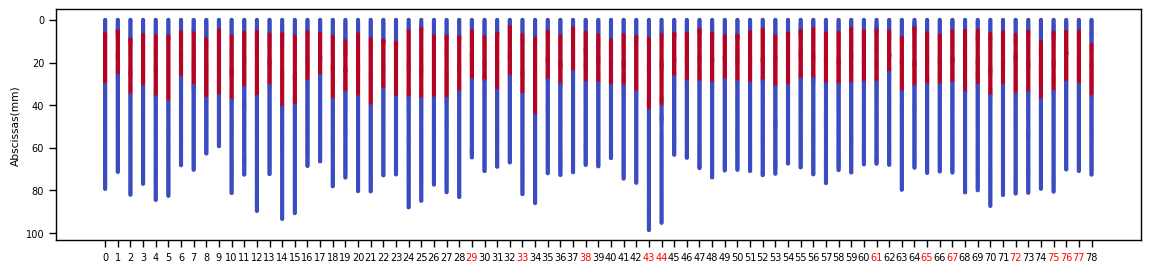

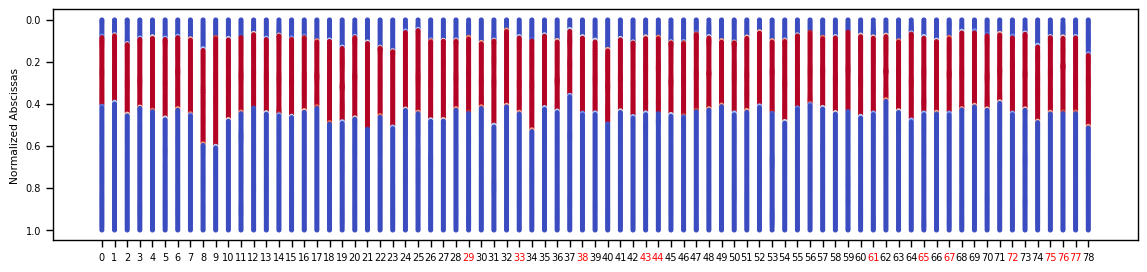

In [ ]:
def create_combined_arrays(curvatures, good_indices, bad_indices, 
                           good_curves, good_masks, bad_curves, bad_predictions):
    """
    创建包含 good 和 bad 数据的曲率和掩码数组，保持顺序与 curvatures 一致。
    
    :param curvatures: 原始曲率数组，用于确定最终顺序。
    :param good_indices: good 数据的索引列表。
    :param bad_indices: bad 数据的索引列表。
    :param good_curves: good 数据的曲率数组。
    :param good_masks: good 数据的真实掩码。
    :param bad_curves: bad 数据的曲率数组。
    :param bad_predictions: bad 数据的模型预测掩码。
    :return: new_curvatures, new_masks
    """
    num_samples = curvatures.shape[0]
    new_curvatures = np.zeros_like(curvatures)
    new_masks = np.zeros_like(curvatures)

    # 填充 good 数据
    new_curvatures[good_indices] = good_curves
    new_masks[good_indices] = good_masks

    # 填充 bad 数据
    new_curvatures[bad_indices] = bad_curves
    new_masks[bad_indices] = bad_predictions

    return new_curvatures, new_masks


# 获取 bad 数据的预测标签
bad_predictions = bad_all_predictions  # 来自模型的预测结果

# 创建 new_curvatures 和 new_masks
new_curvatures, new_masks = create_combined_arrays(
    curvatures=curvatures,
    good_indices=good_curve_index,
    bad_indices=bad_curve_index,
    good_curves=good_curvatures,
    good_masks=masks,
    bad_curves=bad_curvatures,
    bad_predictions=bad_predictions
)

def has_single_one_region(mask):
    """
    检测 1D 数列中是否只有一个连续的 1 区域。

    :param mask: 1D numpy 数组，元素为 0 或 1。
    :return: True 如果只有一个连续的 1 区域，否则为 False。
    """
    # 差分操作，找出 1 的起点和终点
    diff = np.diff(mask, prepend=0, append=0)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    
    # 如果起点和终点只对应一个区域，返回 True
    return len(starts) == 1 and len(ends) == 1

# for i in range(len(new_masks)):
#     print ("i", has_single_one_region(new_masks[i]))

# 标准化每个 abscissas[i] 并调整对应的 new_masks[i]
normalized_abscissas = []
rescaled_masks = []

for i in range(len(abscissas)):
    # 标准化 abscissas[i] 到 [0, 1]
    min_val = abscissas[i].min()
    max_val = abscissas[i].max()
    norm_abscissa = (abscissas[i] - min_val) / (max_val - min_val)
    normalized_abscissas.append(norm_abscissa)

    # 压缩或拉伸 new_masks[i] 到与 norm_abscissa 的比例一致
    interp_mask = np.interp(norm_abscissa, np.linspace(0, 1, len(new_masks[i])), new_masks[i])
    rescaled_masks.append(interp_mask)

normalized_abscissas = np.array(normalized_abscissas, dtype=object)
rescaled_masks = np.array(rescaled_masks, dtype=object)

fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(111)
for i in range(len(reparam_curvatures)):
    ax1.scatter(np.ones(reparam_curvatures[i].shape)*i, abscissas[i], c=new_masks[i], s=5, cmap='coolwarm')
# ax1.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串
ax1.set_xticks(range(len(reparam_curvatures)))  # 设置 xtick 的位置
ax1.set_xticklabels(range(len(reparam_curvatures)))  # 设置 xtick 的标签为数字
# ax1.autoscale(enable=True, axis='x', tight=True)
# ax1.autoscale(enable=True, axis='y', tight=True)
ax1.set_ylabel('Abscissas(mm)')
ax1.invert_yaxis()
for tick, index in zip(ax1.get_xticklabels(), range(len(reparam_curvatures))):
    if index in bad_curve_index:
        tick.set_color('red')
plt.show()

fig = plt.figure(figsize=(14, 3))
ax1 = fig.add_subplot(111)

for i in range(len(reparam_curvatures)):
    ax1.scatter(
        np.ones(normalized_abscissas[i].shape) * i,
        normalized_abscissas[i],
        c=rescaled_masks[i],
        s=8,
        cmap='coolwarm'
    )


# ax1.set_xticks(ticks=range(len(files)), labels=files_label, rotation=90)  # 将x轴标签设置为files中的字符串

ax1.set_xticks(range(len(reparam_curvatures)))  # 设置 xtick 的位置
ax1.set_xticklabels(range(len(reparam_curvatures)))  # 设置 xtick 的标签为数字
ax1.invert_yaxis()
# ax1.autoscale(enable=True, axis='x', tight=True)
ax1.set_ylabel('Normalized Abscissas')
# 修改 bad_curve_index 中 xtick 的颜色为红色
for tick, index in zip(ax1.get_xticklabels(), range(len(reparam_curvatures))):
    if index in bad_curve_index:
        tick.set_color('red')
plt.show()


(79, 2)


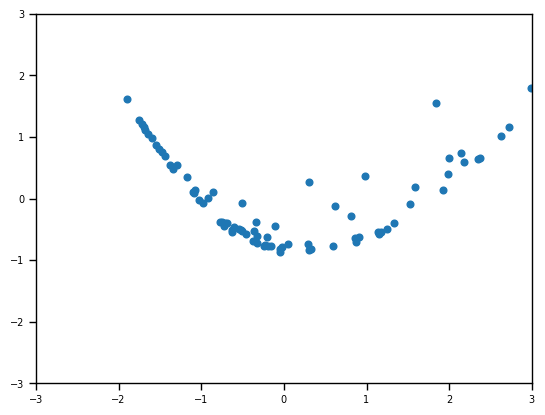

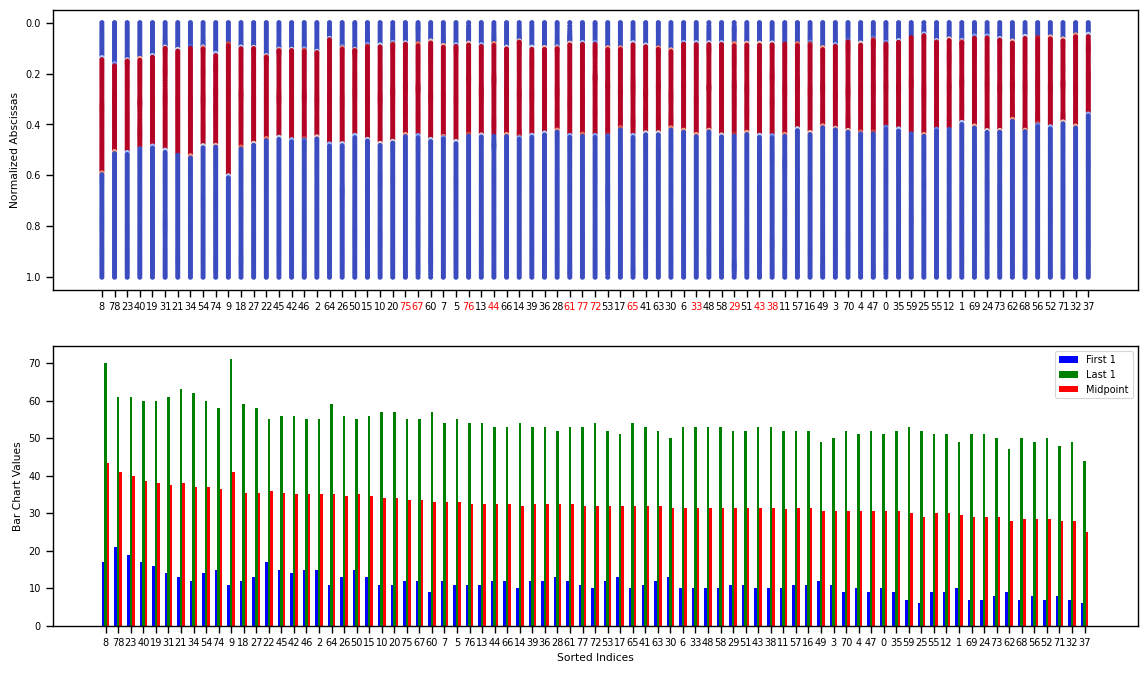

In [120]:
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rescaled_masks)
print(pca_result.shape)
plt.plot(pca_result[:, 0], pca_result[:, 1], 'o')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

# 获取按照 pca_result[:,0] 排序的索引
sorted_indices = np.argsort(-pca_result[:, 0])  # 从大到小排序

# 重新排序数据
sorted_abscissas = [normalized_abscissas[i] for i in sorted_indices]
sorted_rescaled_masks = [rescaled_masks[i] for i in sorted_indices]

# 绘制图形
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

# ax1: scatter 图
for i, idx in enumerate(sorted_indices):  # 按排序后的索引绘制
    ax1.scatter(
        np.ones(sorted_abscissas[i].shape) * i,  # 使用新的 x 顺序
        sorted_abscissas[i],
        c=sorted_rescaled_masks[i],
        s=8,
        cmap='coolwarm'
    )

# 设置 xticks 和 xticklabels，保持原来的数据索引
ax1.set_xticks(range(len(reparam_curvatures)))
ax1.set_xticklabels(sorted_indices)  # 显示排序后的索引

# ax2: bar chart
for i, idx in enumerate(sorted_indices):  # 按排序后的索引绘制
    mask = sorted_rescaled_masks[i]
    
    # 找到第一个为 1 的位置
    first_one = np.where(mask == 1)[0][0] if 1 in mask else 0
    
    # 找到最后一个为 1 的位置
    last_one = np.where(mask == 1)[0][-1] if 1 in mask else 0
    
    # 找到连续 1 序列的中点
    if first_one < last_one:
        midpoint = (first_one + last_one) / 2
    else:
        midpoint = 0  # 如果没有连续 1，则中点为 0

    # 绘制三个 bar
    ax2.bar(i - 0.2, first_one, width=0.2, color='blue', label='First 1' if i == 0 else "")
    ax2.bar(i, last_one, width=0.2, color='green', label='Last 1' if i == 0 else "")
    ax2.bar(i + 0.2, midpoint, width=0.2, color='red', label='Midpoint' if i == 0 else "")

# 添加图例
ax2.legend()
ax2.set_xticks(range(len(reparam_curvatures)))
ax2.set_xticklabels(sorted_indices)  # 显示排序后的索引

# 修改 bad_curve_index 中 xtick 的颜色为红色
for tick, index in zip(ax1.get_xticklabels(), sorted_indices):
    if index in bad_curve_index:
        tick.set_color('red')

# ax1: 设置 y 轴和方向
ax1.invert_yaxis()
ax1.set_ylabel('Normalized Abscissas')

# ax2: 设置标签
ax2.set_ylabel('Bar Chart Values')
ax2.set_xlabel('Sorted Indices')
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 提取连续为 1 的起点和终点
start_indices = []
end_indices = []

for mask in rescaled_masks:
    if 1 in mask:
        start = np.where(mask == 1)[0][0]
        end = np.where(mask == 1)[0][-1]
    else:
        start = 0
        end = 0
    start_indices.append(start)
    end_indices.append(end)

start_indices = np.array(start_indices)
end_indices = np.array(end_indices)

# 准备特征和目标变量
X = pca_result[:, 0].reshape(-1, 1)  # 主成分作为特征
y_start = start_indices  # 起点索引
y_end = end_indices  # 终点索引

# 拟合起点和终点的回归模型
start_model = LinearRegression()
end_model = LinearRegression()

start_model.fit(X, y_start)
end_model.fit(X, y_end)

# 预测起点和终点
y_start_pred = start_model.predict(X)
y_end_pred = end_model.predict(X)

# 评估模型性能
print("Start Index Regression:")
print(f"  MSE: {mean_squared_error(y_start, y_start_pred):.2f}")
print(f"  R2: {r2_score(y_start, y_start_pred):.2f}")

print("End Index Regression:")
print(f"  MSE: {mean_squared_error(y_end, y_end_pred):.2f}")
print(f"  R2: {r2_score(y_end, y_end_pred):.2f}")

# 可视化结果
plt.figure(figsize=(12, 6))

# 起点回归结果
plt.subplot(2, 1, 1)
plt.scatter(X, y_start, label="True Start Indices", color="blue", alpha=0.6)
plt.plot(X, y_start_pred, label="Predicted Start Indices", color="red", linewidth=2)
plt.title("Start Index Regression")
plt.xlabel("PCA Component 1")
plt.ylabel("Start Index")
plt.legend()

# 终点回归结果
plt.subplot(2, 1, 2)
plt.scatter(X, y_end, label="True End Indices", color="blue", alpha=0.6)
plt.plot(X, y_end_pred, label="Predicted End Indices", color="red", linewidth=2)
plt.title("End Index Regression")
plt.xlabel("PCA Component 1")
plt.ylabel("End Index")
plt.legend()

plt.tight_layout()
plt.show()


In [105]:
print (rescaled_masks.shape)

(79, 120)
